# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-2.341534,False,-4.762551
1,-1.745528,False,-3.134729
2,0.783259,False,2.356550
3,-0.557420,True,2.712726
4,-0.207072,False,0.813475
...,...,...,...
995,-2.400580,False,-6.188552
996,-0.854212,False,-1.998392
997,-0.546931,True,3.280933
998,-0.131038,True,5.639356


<AxesSubplot:xlabel='v0'>

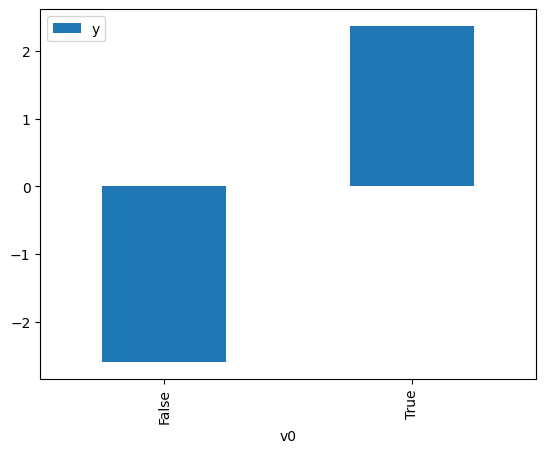

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

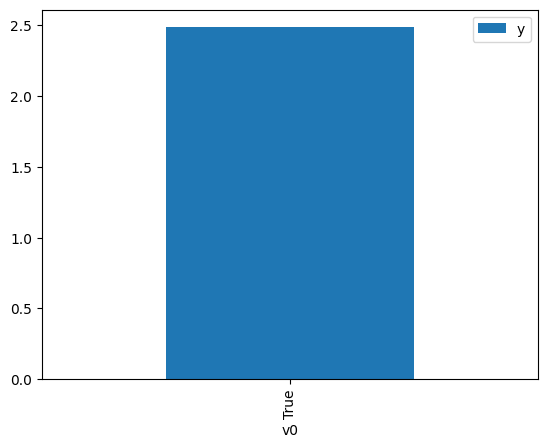

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.079077,False,0.164130,0.480166,2.082613
1,0.437206,False,0.342976,0.393292,2.542640
2,-1.277452,False,-2.462783,0.779363,1.283099
3,-1.335501,False,-3.173001,0.789075,1.267307
4,-1.758699,False,-4.021069,0.850409,1.175904
...,...,...,...,...,...
995,0.539760,False,0.489663,0.369375,2.707279
996,-2.055852,False,-6.091712,0.884079,1.131120
997,-2.052948,False,-5.780659,0.883785,1.131497
998,-1.599037,False,-5.910928,0.829196,1.205987


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.767763,True,2.778000,0.319085,3.133956
1,1.366785,True,9.362889,0.794565,1.258551
2,-1.981854,True,-0.248719,0.123633,8.088479
3,0.938956,True,9.107511,0.717000,1.394701
4,-2.400682,True,-1.571676,0.085286,11.725322
...,...,...,...,...,...
995,-0.637475,True,2.424873,0.347704,2.876013
996,-0.021765,True,4.370359,0.494917,2.020543
997,-2.054378,True,-0.514970,0.116070,8.615477
998,-0.093198,True,4.595465,0.477274,2.095234


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              9295.
Date:                Sun, 21 Aug 2022   Prob (F-statistic):                        0.00
Time:                        18:11:00   Log-Likelihood:                         -1417.4
No. Observations:                1000   AIC:                                      2839.
Df Residuals:                     998   BIC:                                      2849.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5859      0.022    116.215      0.000       2.542       2.630
x2             5.0869      0.058     87.757      0.000       4.973       5.201
==============================================================================
Omnibus:                        0.044   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.978   Jarque-Bera (JB):                0.023
Skew:                           0.011   Prob(JB):                        0.989
Kurtosis:                       3.005   Cond. No.                         2.64
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""